# Disaster Tweet Classification (BERT) Model
## Run several BERT models from TensorFlow Hub, compare results and save them

 - Load and Run BERT models from [TensorFlow hub](https://www.tensorflow.org/hub)
 - Save Trained models
 - Generate csv classification results

In [ ]:
#!pip install -q tensorflow-text

In [ ]:
#!pip install -q tf-models-official

In [ ]:
import bert_classifier as bc

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

In [ ]:
    def plot(hist):
        """
        plot training and validation loss and accuracy for internal use
        hist: History object returned from training
        """
        history_dict = hist.history

        acc = history_dict['binary_accuracy']
        val_acc = history_dict['val_binary_accuracy']
        loss = history_dict['loss']
        val_loss = history_dict['val_loss']

        epochs = range(1, len(acc) + 1)
        fig = plt.figure(figsize=(10, 6))
        fig.tight_layout()

        plt.subplot(2, 1, 1)
        # "bo" is for "blue dot"
        plt.plot(epochs, loss, 'r', label='Training loss')
        # b is for "solid blue line"
        plt.plot(epochs, val_loss, 'b', label='Validation loss')
        plt.title('Training and validation loss')
        # plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(2, 1, 2)
        plt.plot(epochs, acc, 'r', label='Training acc')
        plt.plot(epochs, val_acc, 'b', label='Validation acc')
        plt.title('Training and validation accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend(loc='lower right')

In [ ]:
import csv

# helper batch function yield every n(batch size) in the list l
def batched(l, n):
    for i in range(0, len(l), n):
        yield l[i:i+n]
        
# helper function for kaggle submission
def generate_submission(model, test_df, csv_file):
    '''
        model: trained model for prediction
        test_df: pandas df containing test data
        csv_file: name of the output file in below format
        
        id,target
        0,0
        2,0
        3,1
        9,0
        11,0
    '''
    print(f'loading id, text data...')
    ids = test_df.index.tolist()
    texts = test_df.pop('text').tolist()
    
    rows = []
    for i, t in zip(ids, texts):
        rows.append((i,t))
    
    fields = ['id','target']
    print(f'starting processing...')
    total = len(ids)
    batch_size=100
    print_rows = []
    with open(csv_file, 'w') as f:
        write = csv.writer(f)
        write.writerow(fields)
        index=0
        for batch in batched(rows, batch_size):
            print(f'processing {index}-{index+batch_size} of {total}...')
            ids = [x for x,_ in batch]
            ts = [y for _,y in batch]
            print(f'predicting on the batch...')
            preds = model.predict(ts)
            print(f'prediction complete...')
            for ii,pp in zip(ids,preds):
                print_rows.append([ii,pp])
            index+=batch_size
        print(f'creating output file:{csv_file}...')
        write.writerows(print_rows)
    
    print('file created.')

## 1. [BERT-Base, Uncased](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4): trained weights released by the original BERT authors

In [ ]:
model = bc.BertClassifierModel()

In [ ]:
model.load_df('../data/train.csv', 'id', 'text', 'target')

loading csv ../data/train.csv, index col = id
splitting train/test. test size = 0.2


In [ ]:
model.build_model(preprocess_handle="https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
                 encoder_handle="https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

Building model. preprocessor=https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3, encoder=https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
Model build succeeded.


In [ ]:
model.train(num_epochs = 15, lr=3e-5, optimizer_name='adamw')

Epoch 1/15
191/191 [==============================] - 204s 994ms/step - loss: 0.0394 - binary_accuracy: 0.9851 - val_loss: 0.0455 - val_binary_accuracy: 0.9849
Epoch 2/15
191/191 [==============================] - 188s 986ms/step - loss: 0.0798 - binary_accuracy: 0.9758 - val_loss: 0.0384 - val_binary_accuracy: 0.9857
Epoch 3/15
191/191 [==============================] - 188s 987ms/step - loss: 0.0693 - binary_accuracy: 0.9751 - val_loss: 0.0364 - val_binary_accuracy: 0.9852
Epoch 4/15
191/191 [==============================] - 188s 986ms/step - loss: 0.0698 - binary_accuracy: 0.9780 - val_loss: 0.0374 - val_binary_accuracy: 0.9869
Epoch 5/15
191/191 [==============================] - 188s 987ms/step - loss: 0.0577 - binary_accuracy: 0.9809 - val_loss: 0.0274 - val_binary_accuracy: 0.9885
Epoch 6/15
191/191 [==============================] - 188s 986ms/step - loss: 0.0435 - binary_accuracy: 0.9855 - val_loss: 0.0217 - val_binary_accuracy: 0.9897
Epoch 7/15
191/191 [====================

In [ ]:
#Creating test data for evaluation. manualy labelled around 100 test data.
df_test = pd.read_csv('../data/test_labeled.csv', index_col='id')
test_data = df_test.pop('text')
target_data = df_test.pop('target')
raw_dataset_test = tf.data.Dataset.from_tensor_slices((test_data, target_data))

In [ ]:
type(raw_dataset_test)

tensorflow.python.data.ops.dataset_ops.TensorSliceDataset

In [ ]:
dataset_test = raw_dataset_test.shuffle(
                len(raw_dataset_test)
            ).batch(
                batch_size=32
            ).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
type(dataset_test)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [ ]:
loss, accuracy = model.model.evaluate(dataset_test)

4/4 [==============================] - 1s 187ms/step - loss: 1.2096 - binary_accuracy: 0.7938


In [ ]:
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

Loss: 1.2096370458602905
Accuracy: 0.7938144207000732


In [ ]:
saved = tf.saved_model.load('../tweet/model/saved')

In [ ]:
inputs = [
    "Typhoon Soudelor kills 28 in China and Taiwan",
    "No don't tell me that!",
    "Apocalypse lighting. #Spokane #wildfires",
    "They should all die! All of them! Everything annihilated!",
    "Apocalypse no! Why artists should not go into the #Fukushima exclusion zone http://t.co/3zqL0qbLUw #nuclear #ura",
    "I'm so happy now."
]

In [ ]:
model.predict(inputs)

[1, 0, 1, 0, 1, 0]

In [ ]:
model_name = 'base_uncased_eph15'
save_path = './saved/' + model_name


In [ ]:
model.save(save_path)

In [ ]:
model.reload(save_path)

Loading pre-trained model from ./saved/base_uncased_eph15
load successful


In [ ]:
model.history

In [ ]:
model.history.history

{'loss': [0.498797744512558,
  0.3385844826698303,
  0.23919177055358887,
  0.176261305809021,
  0.1362796425819397],
 'binary_accuracy': [0.7535303831100464,
  0.8614121675491333,
  0.9090312123298645,
  0.9362890124320984,
  0.951724112033844],
 'val_loss': [0.32231175899505615,
  0.22064617276191711,
  0.17856739461421967,
  0.11209695041179657,
  0.08685344457626343],
 'val_binary_accuracy': [0.8651888370513916,
  0.9149425029754639,
  0.9443349838256836,
  0.9582923054695129,
  0.9678161144256592]}

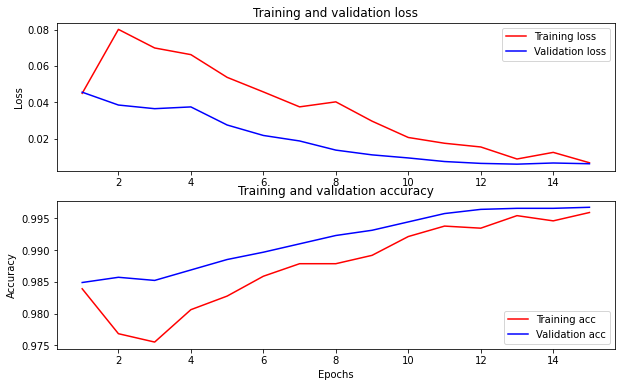

In [ ]:
plot(model.history)

In [ ]:
#load of test csv data
test_df = pd.read_csv('../data/test.csv', index_col='id')

In [ ]:
#generate final prediction csv
outputfile = './output/' + model_name + '.csv'
generate_submission(model, test_df, outputfile)

loading id, text data...
starting processing...
processing 0-100 of 3263...
predicting on the batch...
prediction complete...
processing 100-200 of 3263...
predicting on the batch...
prediction complete...
processing 200-300 of 3263...
predicting on the batch...
prediction complete...
processing 300-400 of 3263...
predicting on the batch...
prediction complete...
processing 400-500 of 3263...
predicting on the batch...
prediction complete...
processing 500-600 of 3263...
predicting on the batch...
prediction complete...
processing 600-700 of 3263...
predicting on the batch...
prediction complete...
processing 700-800 of 3263...
predicting on the batch...
prediction complete...
processing 800-900 of 3263...
predicting on the batch...
prediction complete...
processing 900-1000 of 3263...
predicting on the batch...
prediction complete...
processing 1000-1100 of 3263...
predicting on the batch...
prediction complete...
processing 1100-1200 of 3263...
predicting on the batch...
prediction c

## result: score 0.81734(81.74%)

## 2. [BERT trained on Wikipedia and BooksCorpus and fine-tuned on SST-2](https://tfhub.dev/google/experts/bert/wiki_books/sst2/2)

- Bert-base architecture model fine-tuned for sentiment analysis

In [ ]:
model_name = 'experts_wiki_books_sst2'
save_path = './saved/' + model_name

In [ ]:
model.build_model(preprocess_handle="https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
                 encoder_handle="https://tfhub.dev/google/experts/bert/wiki_books/sst2/2")

Building model. preprocessor=https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3, encoder=https://tfhub.dev/google/experts/bert/wiki_books/sst2/2
Model build succeeded.


In [ ]:
model.train(num_epochs = 9, lr=3e-5, optimizer_name='adamw')

Epoch 1/9
191/191 [==============================] - 202s 997ms/step - loss: 0.0509 - binary_accuracy: 0.9825 - val_loss: 0.0582 - val_binary_accuracy: 0.9847
Epoch 2/9
191/191 [==============================] - 188s 988ms/step - loss: 0.1109 - binary_accuracy: 0.9706 - val_loss: 0.0523 - val_binary_accuracy: 0.9867
Epoch 3/9
191/191 [==============================] - 189s 989ms/step - loss: 0.0864 - binary_accuracy: 0.9758 - val_loss: 0.0439 - val_binary_accuracy: 0.9869
Epoch 4/9
191/191 [==============================] - 189s 989ms/step - loss: 0.0750 - binary_accuracy: 0.9801 - val_loss: 0.0385 - val_binary_accuracy: 0.9878
Epoch 5/9
191/191 [==============================] - 189s 990ms/step - loss: 0.0700 - binary_accuracy: 0.9793 - val_loss: 0.0512 - val_binary_accuracy: 0.9847
Epoch 6/9
191/191 [==============================] - 189s 990ms/step - loss: 0.0488 - binary_accuracy: 0.9836 - val_loss: 0.0327 - val_binary_accuracy: 0.9888
Epoch 7/9
191/191 [===========================

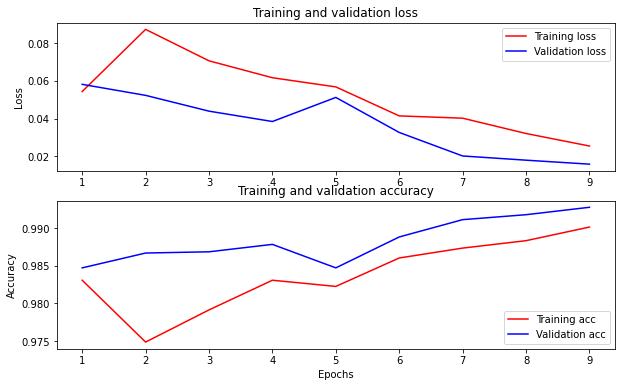

In [ ]:
plot(model.history)

In [ ]:
model.save(save_path)

INFO:tensorflow:Assets written to: ./saved/experts_wiki_books_sst2/assets


INFO:tensorflow:Assets written to: ./saved/experts_wiki_books_sst2/assets


In [ ]:
#load of test csv data
test_df = pd.read_csv('../data/test.csv', index_col='id')

In [ ]:
#generate final prediction csv
outputfile = './output/' + model_name + '.csv'
generate_submission(model, test_df, outputfile)

loading id, text data...
starting processing...
processing 0-100 of 3263...
predicting on the batch...
prediction complete...
processing 100-200 of 3263...
predicting on the batch...
prediction complete...
processing 200-300 of 3263...
predicting on the batch...
prediction complete...
processing 300-400 of 3263...
predicting on the batch...
prediction complete...
processing 400-500 of 3263...
predicting on the batch...
prediction complete...
processing 500-600 of 3263...
predicting on the batch...
prediction complete...
processing 600-700 of 3263...
predicting on the batch...
prediction complete...
processing 700-800 of 3263...
predicting on the batch...
prediction complete...
processing 800-900 of 3263...
predicting on the batch...
prediction complete...
processing 900-1000 of 3263...
predicting on the batch...
prediction complete...
processing 1000-1100 of 3263...
predicting on the batch...
prediction complete...
processing 1100-1200 of 3263...
predicting on the batch...
prediction c

## result: score 0.82071(82.07%)

## 3. [BERT with Talking-Heads Attention and Gated GELU](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/2)
- has two improvements to the core of the Transformer architecture

In [ ]:
model_name = 'talkheads_ggelu_base'
save_path = './saved/' + model_name

In [ ]:
model.build_model(preprocess_handle="https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
                 encoder_handle="https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/2")

Building model. preprocessor=https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3, encoder=https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/2


Model build succeeded.


In [ ]:
model.train(num_epochs = 15, lr=3e-5, optimizer_name='adamw')

Epoch 1/15
191/191 [==============================] - 270s 1s/step - loss: 0.6541 - binary_accuracy: 0.5979 - val_loss: 0.3498 - val_binary_accuracy: 0.8496
Epoch 2/15
191/191 [==============================] - 247s 1s/step - loss: 0.4063 - binary_accuracy: 0.8255 - val_loss: 0.2270 - val_binary_accuracy: 0.9182
Epoch 3/15
191/191 [==============================] - 247s 1s/step - loss: 0.3050 - binary_accuracy: 0.8867 - val_loss: 0.1489 - val_binary_accuracy: 0.9484
Epoch 4/15
191/191 [==============================] - 247s 1s/step - loss: 0.2232 - binary_accuracy: 0.9305 - val_loss: 0.0899 - val_binary_accuracy: 0.9700
Epoch 5/15
191/191 [==============================] - 247s 1s/step - loss: 0.1452 - binary_accuracy: 0.9533 - val_loss: 0.0609 - val_binary_accuracy: 0.9813
Epoch 6/15
191/191 [==============================] - 247s 1s/step - loss: 0.1071 - binary_accuracy: 0.9660 - val_loss: 0.0571 - val_binary_accuracy: 0.9854
Epoch 7/15
191/191 [==============================] - 247s

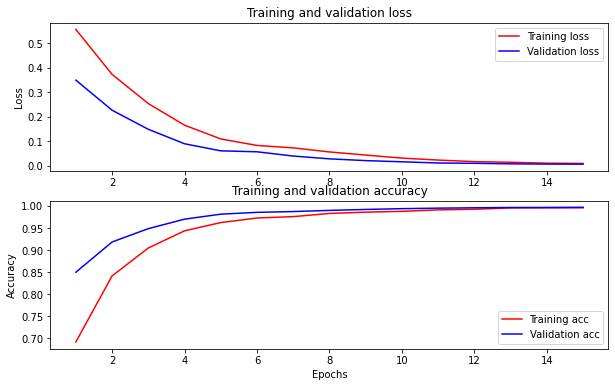

In [ ]:
plot(model.history)

In [ ]:
save_path

'./saved/talkheads_ggelu_base'

In [ ]:
model.save(save_path)

INFO:tensorflow:Assets written to: ./saved/talkheads_ggelu_base/assets


INFO:tensorflow:Assets written to: ./saved/talkheads_ggelu_base/assets


In [ ]:
#load of test csv data
test_df = pd.read_csv('../data/test.csv', index_col='id')

In [ ]:
model_name

'talkheads_ggelu_base'

In [ ]:
#generate final prediction csv
outputfile = './output/' + model_name + '.csv'
generate_submission(model, test_df, outputfile)

loading id, text data...
starting processing...
processing 0-100 of 3263...
predicting on the batch...


prediction complete...
processing 100-200 of 3263...
predicting on the batch...
prediction complete...
processing 200-300 of 3263...
predicting on the batch...
prediction complete...
processing 300-400 of 3263...
predicting on the batch...
prediction complete...
processing 400-500 of 3263...
predicting on the batch...
prediction complete...
processing 500-600 of 3263...
predicting on the batch...
prediction complete...
processing 600-700 of 3263...
predicting on the batch...
prediction complete...
processing 700-800 of 3263...
predicting on the batch...
prediction complete...
processing 800-900 of 3263...
predicting on the batch...
prediction complete...
processing 900-1000 of 3263...
predicting on the batch...
prediction complete...
processing 1000-1100 of 3263...
predicting on the batch...
prediction complete...
processing 1100-1200 of 3263...
predicting on the batch...
prediction complete...
processing 1200-1300 of 3263...
predicting on the batch...
prediction complete...
processing

## result: score 0.81857(81.86%)

## Conclusion: 2nd and 3rd model are more complex than the original BERT base, and takes longer to train, but performs slightly better on Kaggle submission. since the model has to always be fully trained and deployed, accuracy/performance matters more than the training time. will be deploying saved 2nd model.